**Importing Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc


**Load The Dataset**

In [2]:
data = pd.read_csv(r'C:\Users\HP\Desktop\Codsoft\Machine Learning\Spam Classification Dataset\spam.csv', encoding='latin-1')

In [3]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [5]:
data.size

27860

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

**Drop Unnecessarly Columns**

In [8]:
data = data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

In [9]:
data.columns

Index(['v1', 'v2'], dtype='object')

**Rename Columns**

In [10]:
data.columns = ['label', 'message']

**Encoding labels:  `spam` as `1` and `ham` as `0`**

In [11]:
data['labels'] = data['label'].map({'spam': 1, 'ham': 0})

**Initial Data Analysis**

In [12]:
data['message'] = data['message'].str.lower()
data['message'] = data['message'].str.replace(r'[^\w\s]+', '', regex=True)

In [13]:
cleaned_data_head = data.head()
class_distribution = data['label'].value_counts(normalize=True)
print(cleaned_data_head, class_distribution)


  label                                            message  labels
0   ham  go until jurong point crazy available only in ...       0
1   ham                            ok lar joking wif u oni       0
2  spam  free entry in 2 a wkly comp to win fa cup fina...       1
3   ham        u dun say so early hor u c already then say       0
4   ham  nah i dont think he goes to usf he lives aroun...       0 label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64


**Word Cloud Generation**

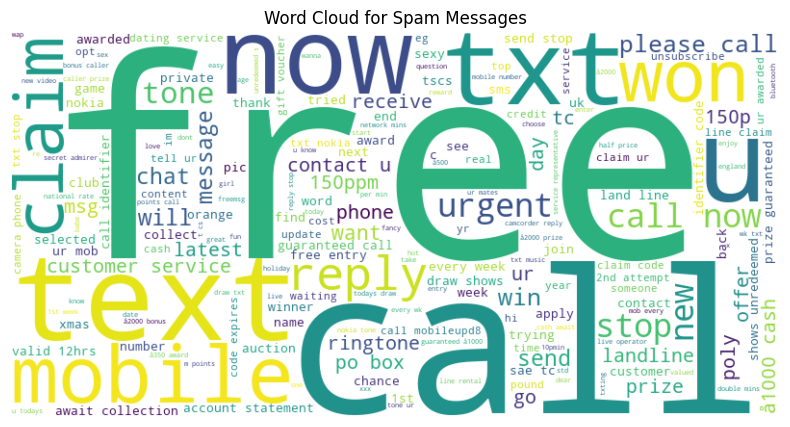

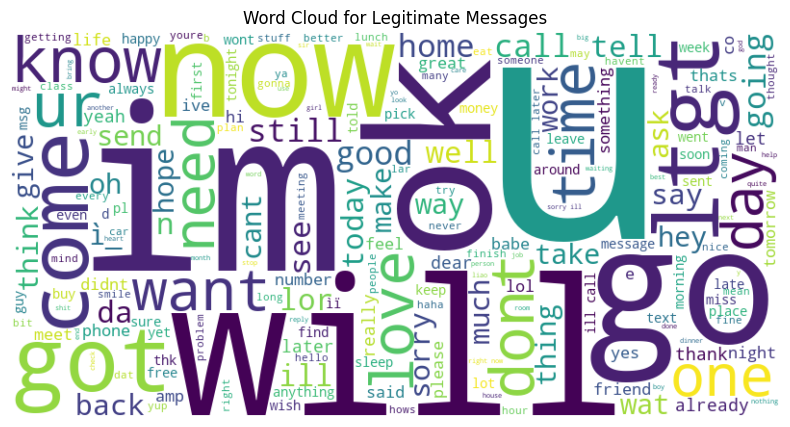

In [14]:
def generate_word_cloud(data, title):
    text = ' '.join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)

spam_messages = data[data['label'] == 'spam']['message']
generate_word_cloud(spam_messages, 'Word Cloud for Spam Messages')

legit_messages = data[data['label'] == 'ham']['message']
generate_word_cloud(legit_messages, 'Word Cloud for Legitimate Messages')


**Message Length Analysis**

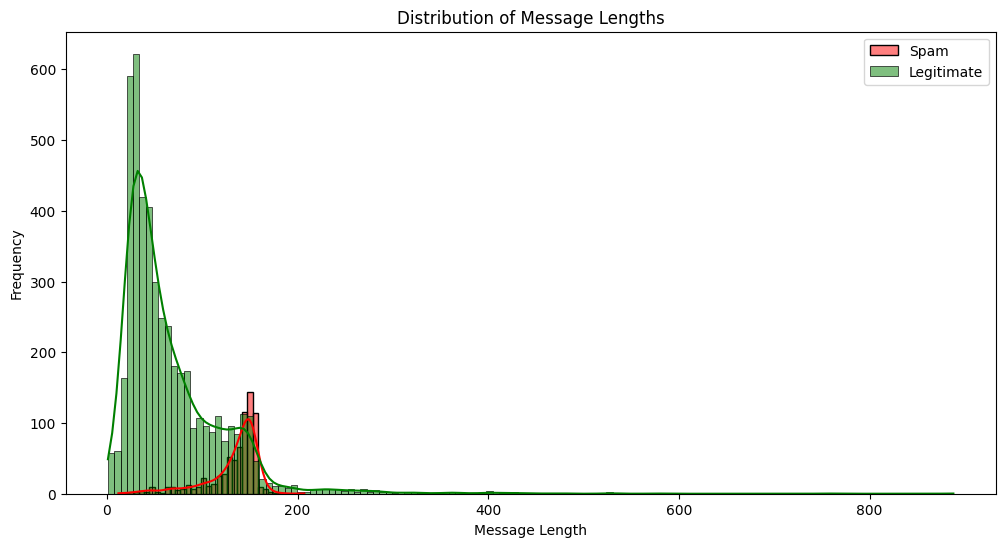

In [15]:
data['message_length'] = data['message'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(data[data['label'] == 'spam']['message_length'], color='red', label='Spam', kde=True)
sns.histplot(data[data['label'] == 'ham']['message_length'], color='green', label='Legitimate', kde=True)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


**Class Distribution Plot**

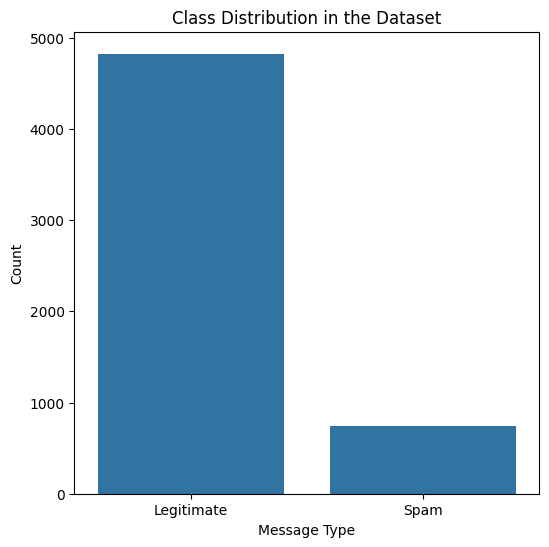

In [16]:
class_distribution = data['label'].value_counts()
plt.figure(figsize=(6, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution in the Dataset')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.xticks(range(2), ['Legitimate', 'Spam'])
plt.show()


**Feature Extraction and Dataset Split**

In [17]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['message'])
y = data['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


**Handling Class Imbalance**

In [18]:
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)


**Model Training and Evaluation**

In [23]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    return accuracy, precision, recall, f1, auc_roc


In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score


In [26]:
nb_accuracy, nb_precision, nb_recall, nb_f1, nb_auc_roc = train_and_evaluate_model(nb_model, X_train_res, y_train_res, X_test, y_test)
lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc_roc = train_and_evaluate_model(lr_model, X_train_res, y_train_res, X_test, y_test)
svm_accuracy, svm_precision, svm_recall, svm_f1, svm_auc_roc = train_and_evaluate_model(svm_model, X_train_res, y_train_res, X_test, y_test)


In [27]:
results = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 'SVM'],
    'Accuracy': [nb_accuracy, lr_accuracy, svm_accuracy],
    'Precision': [nb_precision, lr_precision, svm_precision],
    'Recall': [nb_recall, lr_recall, svm_recall],
    'F1-Score': [nb_f1, lr_f1, svm_f1],
    'AUC-ROC': [nb_auc_roc, lr_auc_roc, svm_auc_roc]
})

print(results)


                 Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0          Naive Bayes  0.972197   0.887006  0.934524  0.910145  0.989880
1  Logistic Regression  0.982960   0.957055  0.928571  0.942598  0.991804
2                  SVM  0.982063   0.993333  0.886905  0.937107  0.992332


In [28]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return report, auc_roc

nb_model = MultinomialNB()
nb_report, nb_auc_roc = train_and_evaluate_model(nb_model, X_train_res, y_train_res, X_test, y_test)

lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_report, lr_auc_roc = train_and_evaluate_model(lr_model, X_train_res, y_train_res, X_test, y_test)

svm_model = SVC(class_weight='balanced', probability=True)
svm_report, svm_auc_roc = train_and_evaluate_model(svm_model, X_train_res, y_train_res, X_test, y_test)


**Confusion Matrix and ROC Curve**

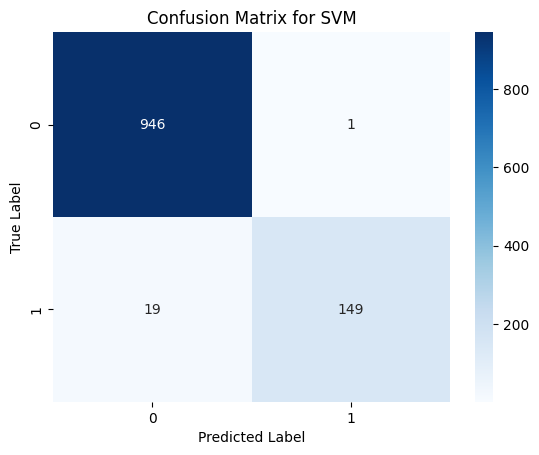

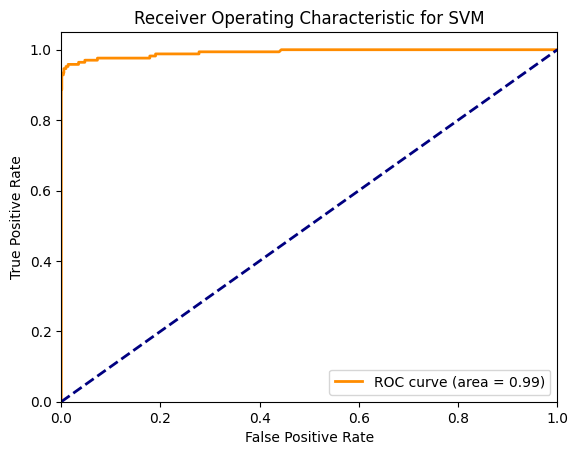

In [20]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

y_pred_svm = svm_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_svm, 'SVM')

y_score_svm = svm_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_score_svm, 'SVM')


**Precision - Recall Curve**

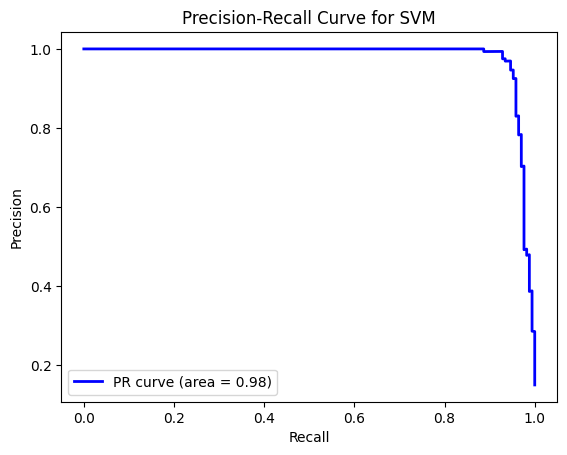

In [21]:
def plot_precision_recall_curve(y_true, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend(loc="lower left")
    plt.show()

plot_precision_recall_curve(y_test, y_score_svm, 'SVM')
